# Прогнозирование заказов такси

## Цель исследования:
Построить модель предсказания, которая спрогнозирует количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.


## Ход исследования:
1. Подготовка данных. Загрузим данные и выполнить их ресемплирование по одному часу для ознакомления с данными.
2. Анализ данных. На данном этапе будет выполнен анализ данных.
3. Обучение моделей. На данном этапе мы cделать тестовую выборку размером 10% от исходных данных и обучим разные модели с различными гиперпараметрами:
- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- CatBoostRegressor
- SARIMA

4. Анализ моделей. Проанализируем данные и делаем вывод о том, какая модель подходит лучше всего.

## Описание данных:
Исторические данные о заказах такси в аэропортах.


Признаки:


количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

Примечание:


значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка данных
Создадим рабочую среду.

In [1]:
!pip install pmdarima

In [2]:
!pip install yellowbrick

In [3]:
!pip install pandas-profiling

In [4]:
import pandas as pd
import time
import datetime
import os
import numpy as np
import math

from yellowbrick.classifier import ClassificationReport
import pandas_profiling

from pandas.api.types import is_string_dtype, is_numeric_dtype
from statsmodels.tsa.seasonal import seasonal_decompose 

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace import sarimax

pd.set_option('display.float_format', lambda x: '%.3f' % x)#меняем формат вывода операции groupby в pandas, 
#которая создает экспоненциальную запись для очень больших чисел
plt.style.use('dark_background')#http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
STATE = 12345


Прочтем данные.

Сделаем столбец с датой - индексом.


Для проверки временной последовательности распределения данных применяем функцию исследования монотонности – pandas.Series.is_monotonic. Применяем ее к столбцу с датой, в нашем случае – к индексу.

In [5]:
df= pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [8]:
report = df.profile_report(title='MPG dataset analysis')
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Рассмотрим основные данные датасета.

In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [11]:
df.shape

(26496, 1)

In [12]:
df.describe()

,num_orders
count,26496.000
mean,14.070
std,9.211
min,0.000
25%,8.000
50%,13.000
75%,19.000
max,119.000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отобразим вид данных, предварительно сделав ресемплирование по часу.

In [14]:
df = df.resample('1H').sum()

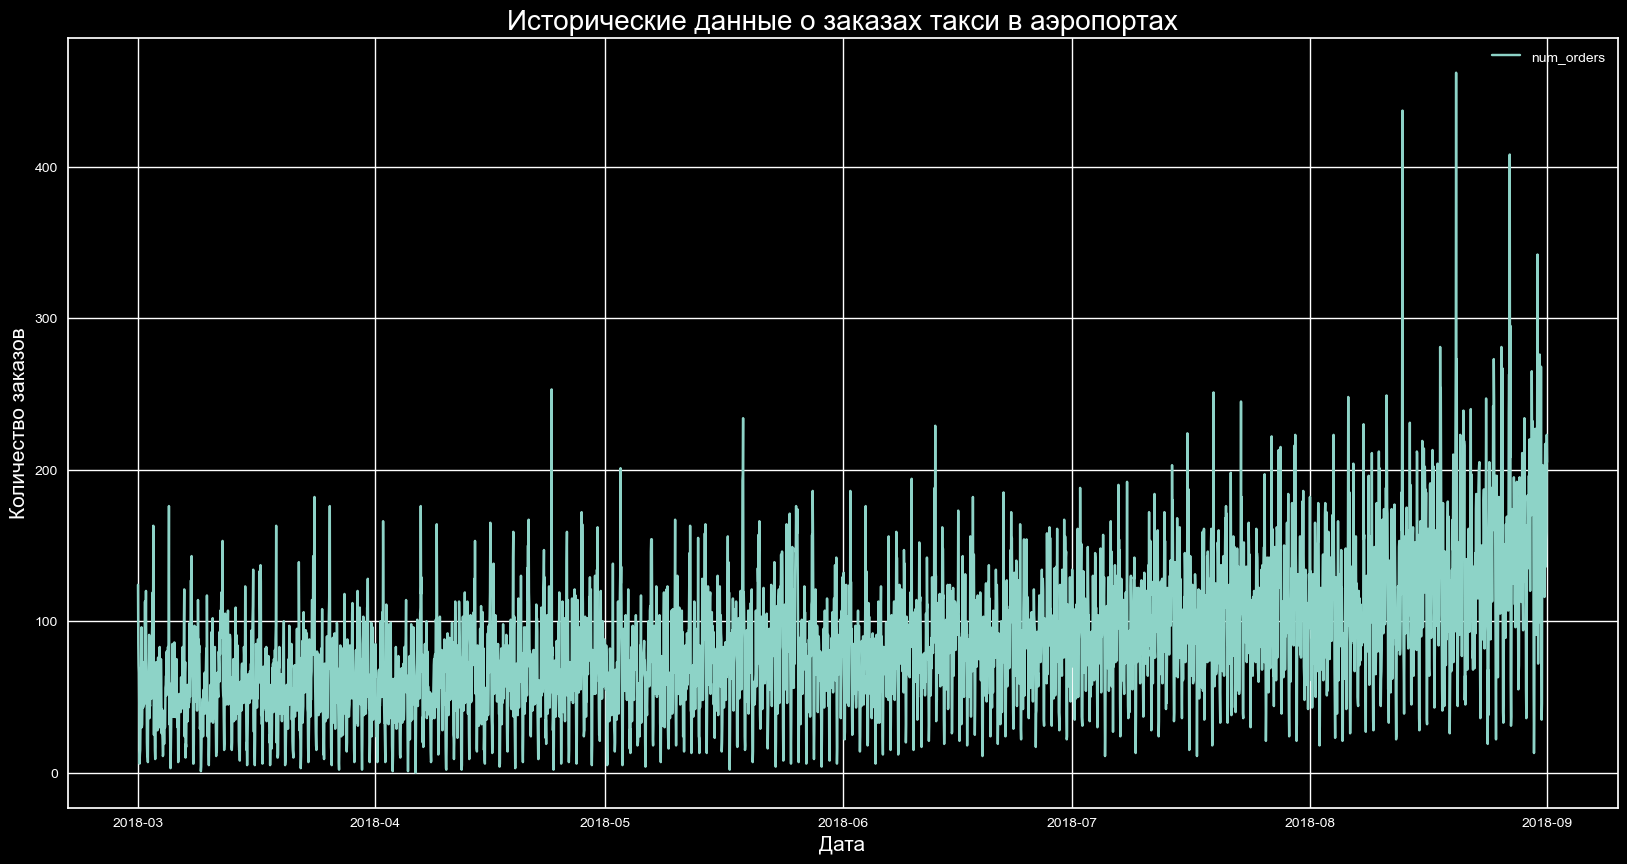

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
plot = sns.lineplot(ax=ax, data=df, legend='auto')
plot.set_title('Исторические данные о заказах такси в аэропортах',
    fontsize=20)
plot.set_xlabel("Дата", fontsize=15)
plot.set_ylabel("Количество заказов", fontsize=15)
plt.show()

Из графика видно:

- Со временем наблюдается тенденция к большему заказу такси из аэропортов.
- Видим, что можно идентифицировать некоторые выбросы.
- Есть относительно большие колебания из недели в неделю, вверх и вниз.
- Колебания в более поздние месяцы кажутся большими, чем колебания в более ранние месяцы.

### Итоги подготовки данных

Мы наблблюдаем данные, которые содержат 26496 наблюдения за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 включительно.

- Количество наблюдений соответствует нашему ожиданию, что означает, что мы обрабатываем данные правильно.
- Среднее значение составляет около 14, что мы могли бы рассмотреть наш уровень в этой серии.
- Стандартное отклонение (средний разброс от среднего) относительно не велик при 9 вызовах такси.
- Процентили вместе со стандартным отклонением указывают на наличие разброса данных.
- Со временем наблюдается тенденция к большему заказу такси из аэропортов.
- Тенденция означает, что набор данных почти наверняка является нестационарным(по наличию или отсутствию тенденций и сезонных эффектов), и очевидное изменение флуктуации также может внести свой вклад.

Далее будет проведен анализ который будет включать изучение: тренда, сезонности и остатков. Рассмотрим сглаживание по неделям.


## Анализ данных


Зададим новый шаг наблюдений и пересчитаем количество событий за новый период(за час).

In [16]:

data = df.resample('1H').sum()

decomposed = seasonal_decompose(x=data['num_orders'],
                                model='additive',
                                extrapolate_trend='freq',
                                period=4)

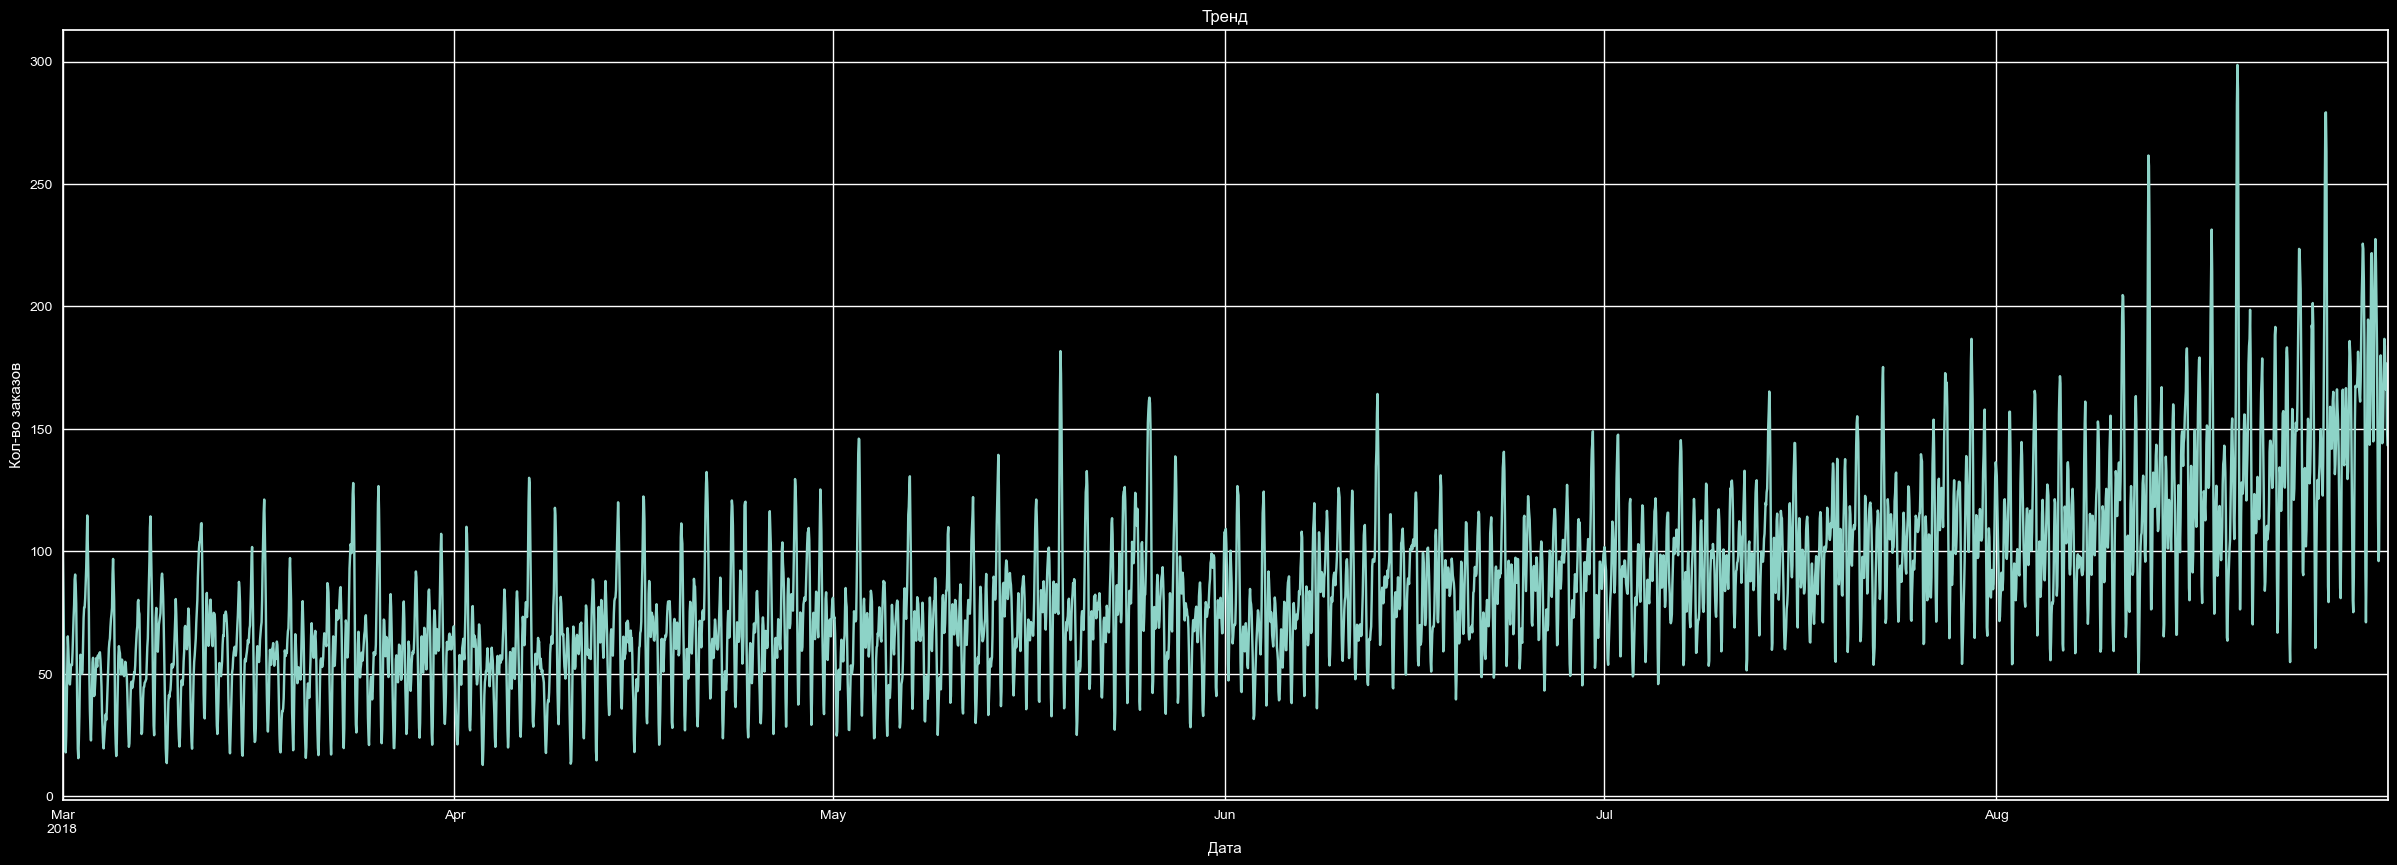

In [17]:
plt.figure(figsize=(30, 10))
plt.subplot()
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

График демонстрирует наличие тренда: со временем увеличение заказов такси из аэропорта.

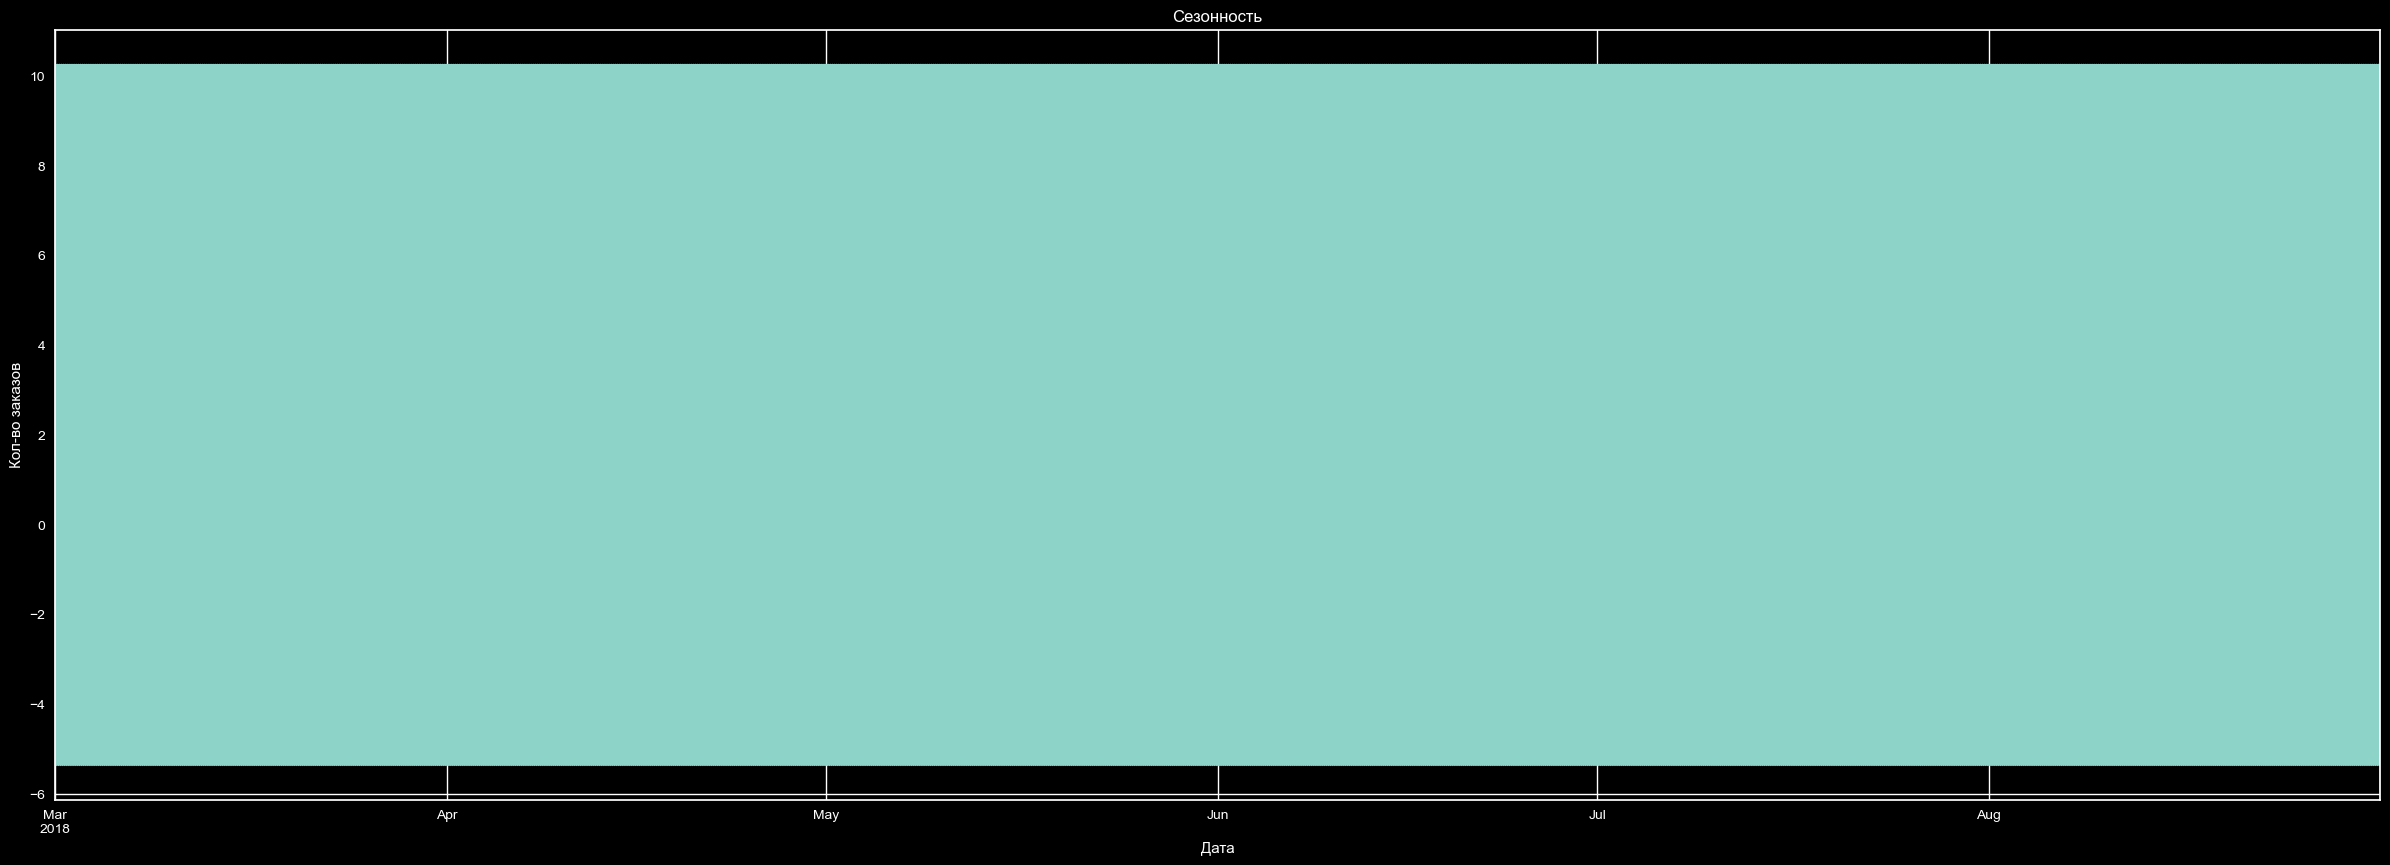

In [18]:
plt.figure(figsize=(30, 10))
plt.subplot()
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

Явно сезонность есть,но что-то сказать о ней невозможно, необходимо взглянуть на срез данных.

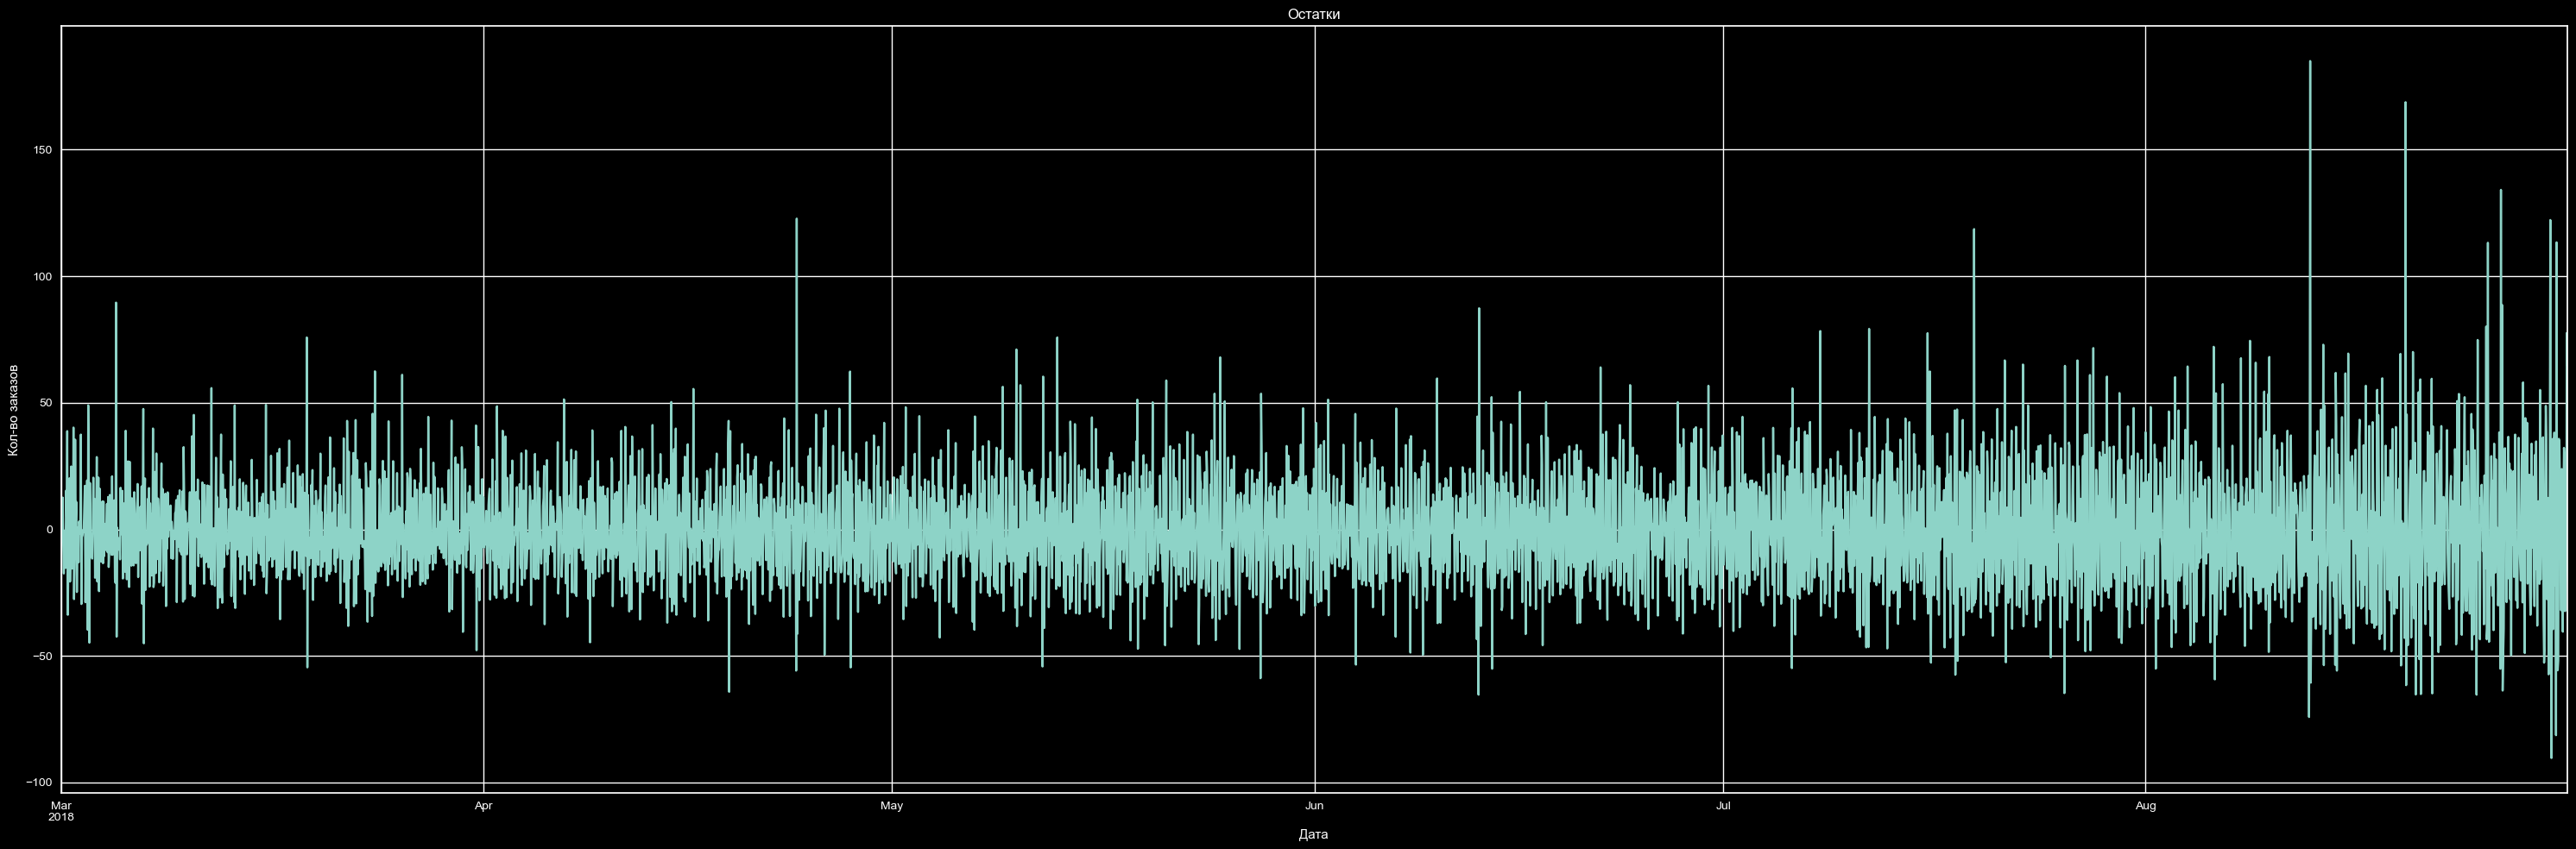

In [19]:
plt.figure(figsize=(30, 10))
plt.subplot()
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.tight_layout()
plt.show()

Остатки идентифицированы.

Рассмотрим данные по часам за последние 3 дня

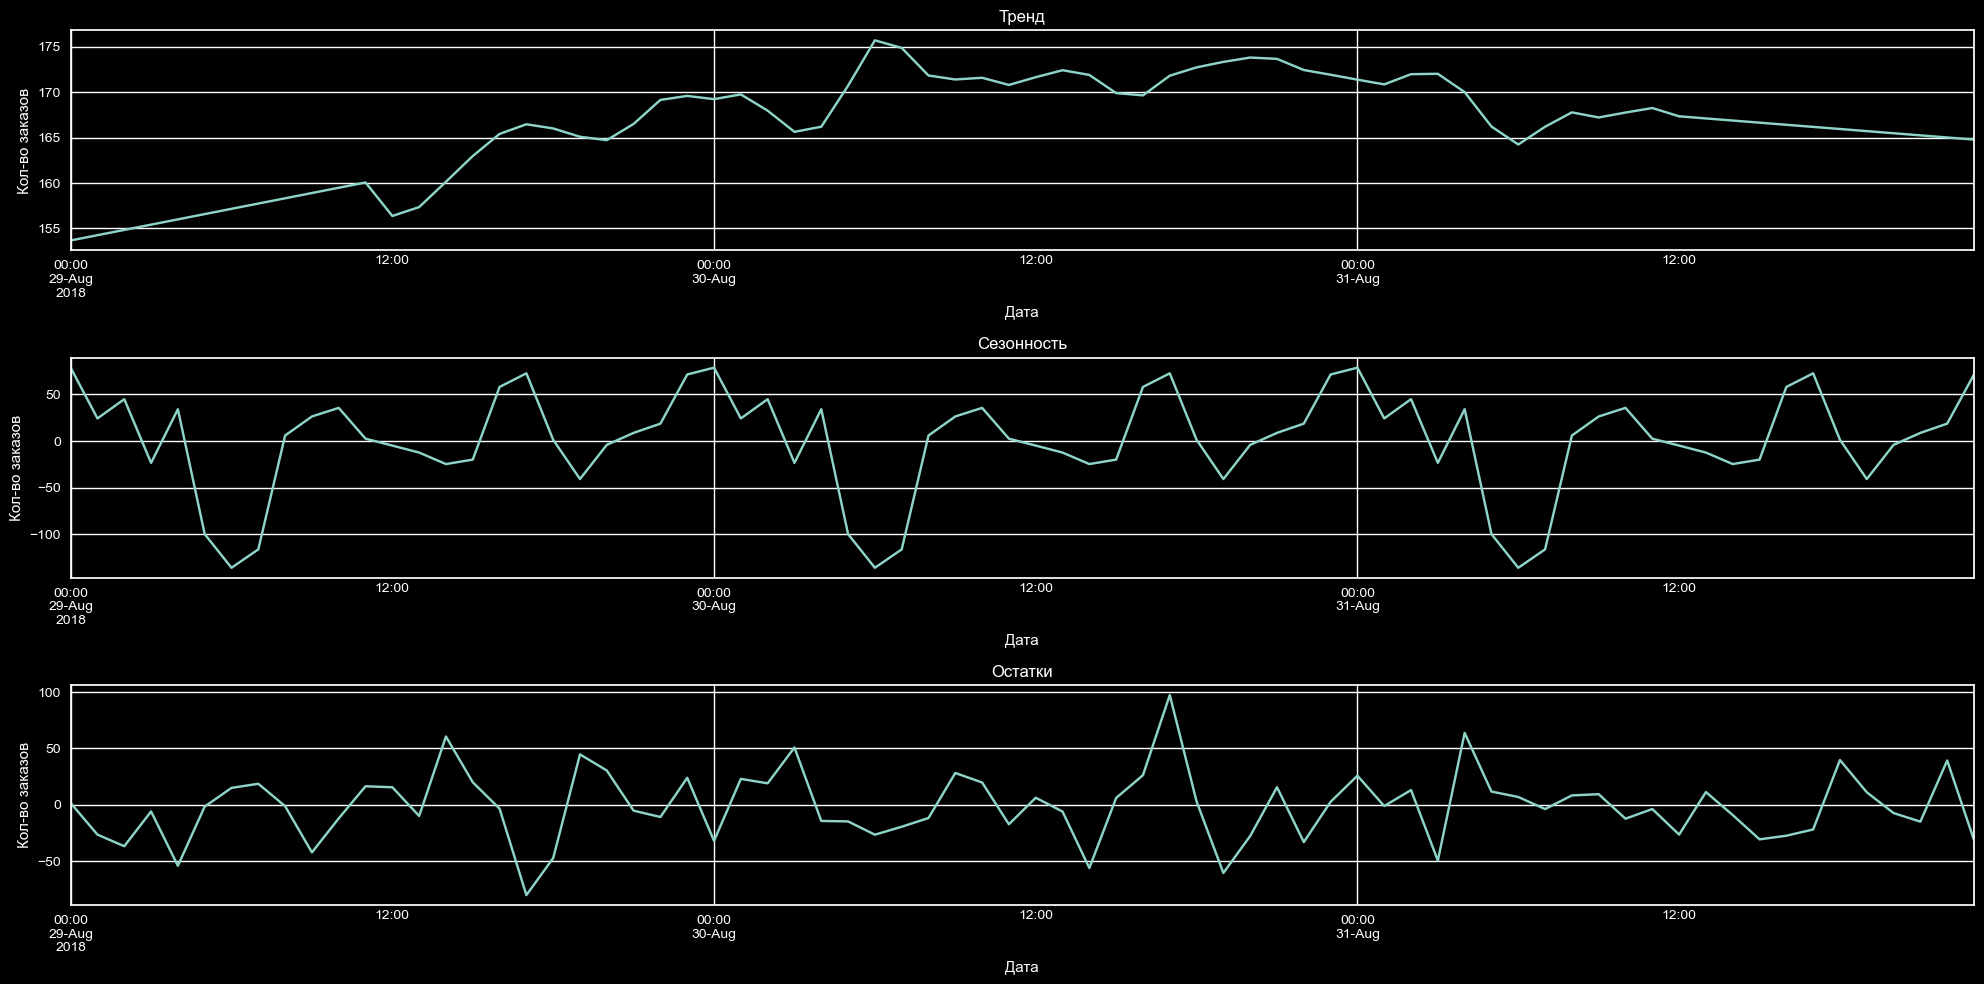

In [20]:
data = df['2018-08-29':'2018-08-31'].resample('H').sum()

decomposed = seasonal_decompose(x=data['num_orders'],
                                model='additive',
                                extrapolate_trend='freq',
                                period=24)
plt.figure(figsize=(20, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.tight_layout()

Видим, что тренд, в общем и целом, отображает увеличение числа заказов со временем, но необходимо рассмотреть данные с использованием скользящего среднего со сдвигом по дням.

На графике сезонности мы хорошо видим, что в районе 4-6 часов наблюдается наибольший спад вызова такси в аэропорт, увеличение числа заказов наблюдается около 10-11 утра, затем около 4-6 часов дня. Начиная с 10 часов вечера и до 12 часов ночи идет увеличение числа заказов и максимум приходится на полночь. Затем спад.

In [21]:
# проведем ресемплирование датафрейма по часу: 
df = df.resample('1H').sum()

In [22]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [23]:
# получим данные скользящего среднего со сдвигом по дням: 
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
df = df.dropna()

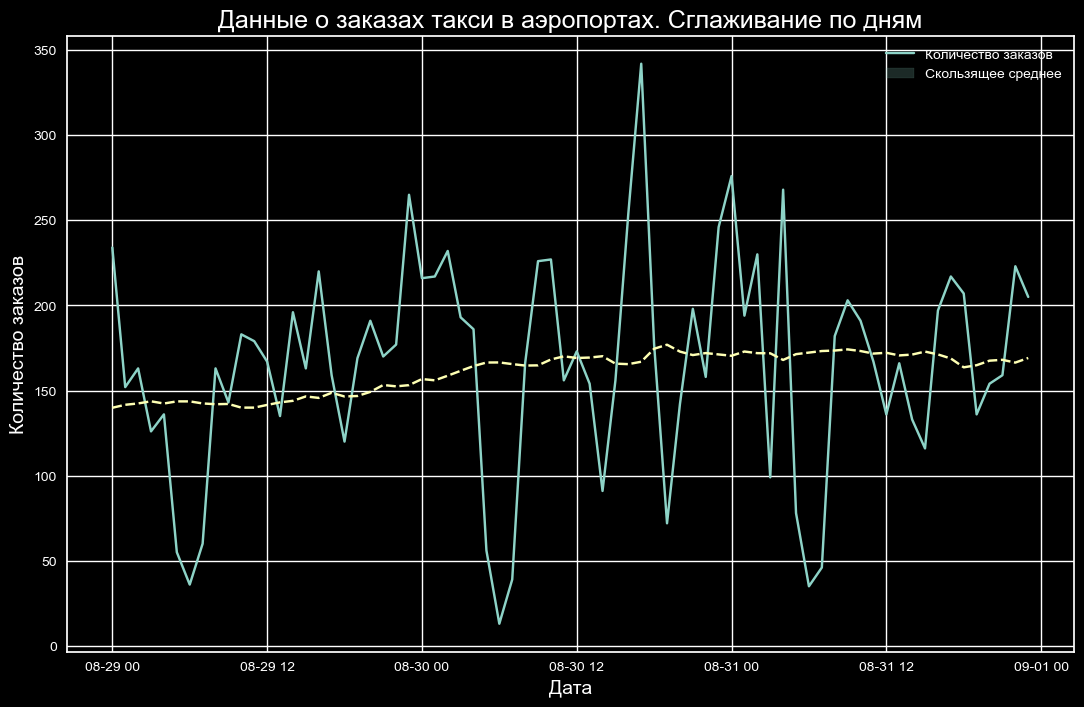

In [24]:
fig, ax = plt.subplots(figsize=(13, 8))
resample_plot = sns.lineplot(ax=ax, data=df['2018-08-29':'2018-08-31'])
resample_plot.set_title(
    'Данные о заказах такси в аэропортах. Сглаживание по дням', fontsize=18)
plt.legend(['Количество заказов', 'Скользящее среднее'])
resample_plot.set_xlabel("Дата", fontsize=14)
resample_plot.set_ylabel("Количество заказов", fontsize=14)
plt.show()

Имеется явно выраженный тренд и сезонность.


### Итоги анализа данных
На основании проведенного анализ было установлено, набор данных является нестационарным так как:
- наблюдвется тренд - тенденция к увеличению числа заказов
- наблюдаются сезонные эффекты: в районе 4-6 часов наблюдается наибольший спад вызова такси в аэропорт, увеличение числа заказов наблюдается около 10-11 утра, затем около 4-6 часов дня. Начиная с 10 часов вечера и до 12 часов ночи идет увеличение числа заказов и максимум приходится на полночь. Затем спад.

Далее будет проведено обучение моделей и тестирование лучшей модели.

## Обучение моделей

Создаем дополнительные временные признаки – выделяем лаг (задержку события). Сдвигаем события на определенное количество шагов вперед. Лаги комбинируются со скользящими окнами. При заметной недельной сезонности и имеющихся данных за каждый день, можно применить rolling_window().

In [25]:
def create_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:, 0].shift(lag)

    data['rolling_mean'] = data.iloc[:, 0].shift().rolling(
        rolling_mean_size).mean()

In [26]:

create_features(df, 1, 24)
df.dropna(how='any', inplace=True)

In [27]:
df.head()

,num_orders,rolling_mean,hour,dayofweek,lag_1
datetime,,,,,
2018-03-03 00:00:00,163,62.750,0,5,72.000
2018-03-03 01:00:00,108,65.792,1,5,163.000
2018-03-03 02:00:00,25,65.292,2,5,108.000
2018-03-03 03:00:00,64,63.208,3,5,25.000
2018-03-03 04:00:00,44,63.208,4,5,64.000


Разделим данные на train и test выборки.

In [28]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [29]:
print(f'Размер обучающей выборки: {train.shape[0]}')
print(f'Размер тестовой выборки: {test.shape[0]}')

Размер обучающей выборки: 3931
Размер тестовой выборки: 437


Выделим признаки и целевой признок для train и test выборок.

In [30]:
features_train = train.drop('num_orders', axis='columns')
target_train = train['num_orders']

features_test = test.drop('num_orders', axis='columns')
target_test = test['num_orders']

Создадим cv выборку для временных рядов через TimeSeriesSplit.

In [31]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

In [32]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 3
cv_time_series_rmse(regressor=LinearRegression(), 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)

32.7917459569882

Создана функция для кроссвалидации временных рядов.

### LinearRegression

In [33]:
model = LinearRegression()

cv_LinearRegression_rmse = cv_time_series_rmse(regressor=model, 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
print(f'Среднее значение RMSE для cv модели {model}: {round(cv_LinearRegression_rmse, 2)}')
lr_results = {'Model': model,
              'Train RMSE': round(cv_LinearRegression_rmse, 2),
              'Test RMSE': '-'
             }

Среднее значение RMSE для cv модели LinearRegression(): 32.79


### Модель - DecisionTreeRegressor

In [34]:
model = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 30, 2)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]
clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
best_params_DecisionTreeRegressor = clf.best_params_
print(f'Лучшие параметры для {model}:')
print(best_params_DecisionTreeRegressor)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
 

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
 

Лучшие параметры для DecisionTreeRegressor():
{'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
35.005561 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
30.157934 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
28.110011 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
29.033307 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
30.709143 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
31.703112 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}
32.415889 for {'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}
32.899561 for {'criterion': 'mse', 'max_depth': 16, 'random_state': 12345}
33.230669 for {'criterion': 'mse', 'max_depth': 18, 'random_state': 12345}
33.312776 for {'criterion': 'mse', 'max_depth': 20, 'random_state': 12345}
33.067950 for {'criterion': 'mse', 'max_depth': 22, 'random_state': 12345}
33.269218 for {'criterion': 'mse', 'max_depth': 24, 'random_state': 12345

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
 

In [35]:
model = DecisionTreeRegressor()
model.set_params(**best_params_DecisionTreeRegressor)

cv_DecisionTreeRegressor_rsme = cv_time_series_rmse(regressor=model, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print(f'Среднее значение RMSE для cv модели {model}: {round(cv_DecisionTreeRegressor_rsme, 2)}')
dt_results = {'Model': model,
              'Train RMSE': round(cv_DecisionTreeRegressor_rsme, 2),
              'Test RMSE': '-'
             }

Среднее значение RMSE для cv модели DecisionTreeRegressor(criterion='mse', max_depth=6, random_state=12345): 32.42


/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


### Модель - RandomForestRegressor

In [36]:
model=RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'max_depth':max_depth_list, 
                'n_estimators':[x for x in range(90,95)],
                'random_state':[12345]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
best_params_RandomForestRegressor = clf.best_params_
print(f'Лучшие параметры для {model}:')
print(best_params_RandomForestRegressor)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/y

Лучшие параметры для RandomForestRegressor():
{'criterion': 'mse', 'max_depth': 10, 'n_estimators': 90, 'random_state': 12345}
33.554034 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 90, 'random_state': 12345}
33.543410 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 91, 'random_state': 12345}
33.547470 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 92, 'random_state': 12345}
33.552165 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 93, 'random_state': 12345}
33.554047 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 94, 'random_state': 12345}
28.783635 for {'criterion': 'mse', 'max_depth': 4, 'n_estimators': 90, 'random_state': 12345}
28.773486 for {'criterion': 'mse', 'max_depth': 4, 'n_estimators': 91, 'random_state': 12345}
28.769729 for {'criterion': 'mse', 'max_depth': 4, 'n_estimators': 92, 'random_state': 12345}
28.767437 for {'criterion': 'mse', 'max_depth': 4, 'n_estimators': 93, 'random_state': 12345}
28.768454 for {'criterion':

In [37]:
model=RandomForestRegressor() 
model.set_params(**best_params_RandomForestRegressor)

cv_RandomForestRegressor_rmse = cv_time_series_rmse(regressor=model, 
                                data=train, 
                                target_column='num_orders', 
                                n_splits=cv_splits, 
                                max_train_size=cv_train_test_split)
print(f'Среднее значение RMSE для cv модели {model}: {round(cv_RandomForestRegressor_rmse, 2)}')
rf_results = {'Model': model,
              'Train RMSE': round(cv_RandomForestRegressor_rmse, 2),
              'Test RMSE': '-'
             }

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Среднее значение RMSE для cv модели RandomForestRegressor(criterion='mse', max_depth=10, n_estimators=90,
                      random_state=12345): 27.99


### Модель - CatBoostRegressor

In [38]:
model = CatBoostRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 5)],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
best_params_CatBoostRegressor = clf.best_params_
print(f'Лучшие параметры для {model}:')
print(best_params_CatBoostRegressor)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

Лучшие параметры для <catboost.core.CatBoostRegressor object at 0x7f813f4c5970>:
{'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
25.214249 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
26.194084 for {'learning_rate': 0.2, 'random_state': 12345, 'verbose': False}
26.567707 for {'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}
26.501785 for {'learning_rate': 0.4, 'random_state': 12345, 'verbose': False}



In [39]:
model = CatBoostRegressor() 
model.set_params(**best_params_CatBoostRegressor)

cv_CatBoostRegressor_rsme = cv_time_series_rmse(regressor=model, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print(f'Среднее значение RMSE для cv модели {model}: {round(cv_CatBoostRegressor_rsme, 2)}')
cbr_results = {'Model': model,
              'Train RMSE': round(cv_CatBoostRegressor_rsme, 2),
              'Test RMSE': '-'
             }

Среднее значение RMSE для cv модели <catboost.core.CatBoostRegressor object at 0x7f813f4c5a60>: 29.43


### Модель - ARIMA(SARIMA)

In [40]:
# проведем автоматический подбор параметров модели: 
model = auto_arima(target_train, 
                  seasonal=True, 
                  m=7, 
                  trace=True, 
                  suppress_warnings=True, 
                  errror_action='ignore', 
                  stepwise=True, 
                  trend='t')
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=38404.928, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=39369.334, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=38987.465, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=38839.662, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=39369.334, Time=0.25 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=38409.183, Time=3.29 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=38394.062, Time=1.35 sec


/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=38398.842, Time=0.73 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=38376.730, Time=6.52 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=38404.331, Time=3.06 sec


/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=38652.723, Time=2.36 sec


/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=39068.877, Time=11.06 sec
 ARIMA(3,1,2)(2,0,0)[7] intercept   : AIC=38219.551, Time=11.95 sec
 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=38417.595, Time=5.68 sec
 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=38373.944, Time=12.09 sec
 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=6.80 sec


/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,0,0)[7] intercept   : AIC=38410.143, Time=10.09 sec
 ARIMA(4,1,2)(2,0,0)[7] intercept   : AIC=38295.030, Time=12.94 sec
 ARIMA(3,1,3)(2,0,0)[7] intercept   : AIC=38176.540, Time=5.87 sec
 ARIMA(3,1,3)(1,0,0)[7] intercept   : AIC=38187.555, Time=3.59 sec
 ARIMA(3,1,3)(2,0,1)[7] intercept   : AIC=38271.590, Time=4.44 sec
 ARIMA(3,1,3)(1,0,1)[7] intercept   : AIC=38270.812, Time=1.71 sec
 ARIMA(2,1,3)(2,0,0)[7] intercept   : AIC=38307.862, Time=6.69 sec
 ARIMA(4,1,3)(2,0,0)[7] intercept   : AIC=inf, Time=11.25 sec
 ARIMA(3,1,4)(2,0,0)[7] intercept   : AIC=38301.640, Time=10.27 sec
 ARIMA(2,1,4)(2,0,0)[7] intercept   : AIC=38390.913, Time=8.29 sec
 ARIMA(4,1,4)(2,0,0)[7] intercept   : AIC=38170.058, Time=20.37 sec
 ARIMA(4,1,4)(1,0,0)[7] intercept   : AIC=inf, Time=6.41 sec
 ARIMA(4,1,4)(2,0,1)[7] intercept   : AIC=inf, Time=25.90 sec
 ARIMA(4,1,4)(1,0,1)[7] intercept   : AIC=inf, Time=8.96 sec
 ARIMA(5,1,4)(2,0,0)[7] intercept   : AIC=inf, Time=62.23 sec
 ARIMA(4,1,5)(2,0,

ARIMA(order=(3, 1, 5), scoring_args={}, seasonal_order=(2, 0, 0, 7),
      suppress_warnings=True, trend='t')

In [41]:
# т.к. модель имеет выраженную сезонность используем модель SARIMAX: 
arima_model = sarimax.SARIMAX(target_train,
                              order=(3,1,5),
                              seasonal_order=(2, 0, 0, 7))
arima_results = arima_model.fit()
print(arima_results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85609D+00    |proj g|=  4.47365D-02


 This problem is unconstrained.



At iterate    5    f=  4.84712D+00    |proj g|=  3.69082D-02

At iterate   10    f=  4.83661D+00    |proj g|=  5.26075D-02

At iterate   15    f=  4.82870D+00    |proj g|=  1.64986D-02

At iterate   20    f=  4.82829D+00    |proj g|=  9.50831D-03

At iterate   25    f=  4.82733D+00    |proj g|=  4.21671D-02

At iterate   30    f=  4.82410D+00    |proj g|=  1.14666D-02

At iterate   35    f=  4.82402D+00    |proj g|=  7.39790D-04

At iterate   40    f=  4.82396D+00    |proj g|=  8.23161D-03

At iterate   45    f=  4.82393D+00    |proj g|=  1.08525D-03

At iterate   50    f=  4.82393D+00    |proj g|=  1.26810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7345      0.159      4.614      0.000       0.422       1.046
ar.L2         -0.7736      0.139     -5.582      0.000      -1.045      -0.502
ar.L3         -0.0490      0.130     -0.377      0.706      -0.304       0.206
ma.L1         -1.3194      0.159     -8.275      0.000      -1.632      -1.007
ma.L2          1.0802      0.234      4.626      0.000       0.623       1.538
ma.L3         -0.4839      0.187     -2.591      0.010      -0.850      -0.118
ma.L4         -0.1323      0.077     -1.717      0.086      -0.283       0.019
ma.L5         -0.1301      0.040     -3.272      0.001      -0.208      -0.052
ar.S.L7       -0.0473      0.019     -2.429      0.015      -0.085      -0.009
ar.S.L14      -0.0779      0.018     -4.363      0.000      -0.113      -0.043
sigma2       907.4124     14.493     62.610      0.0

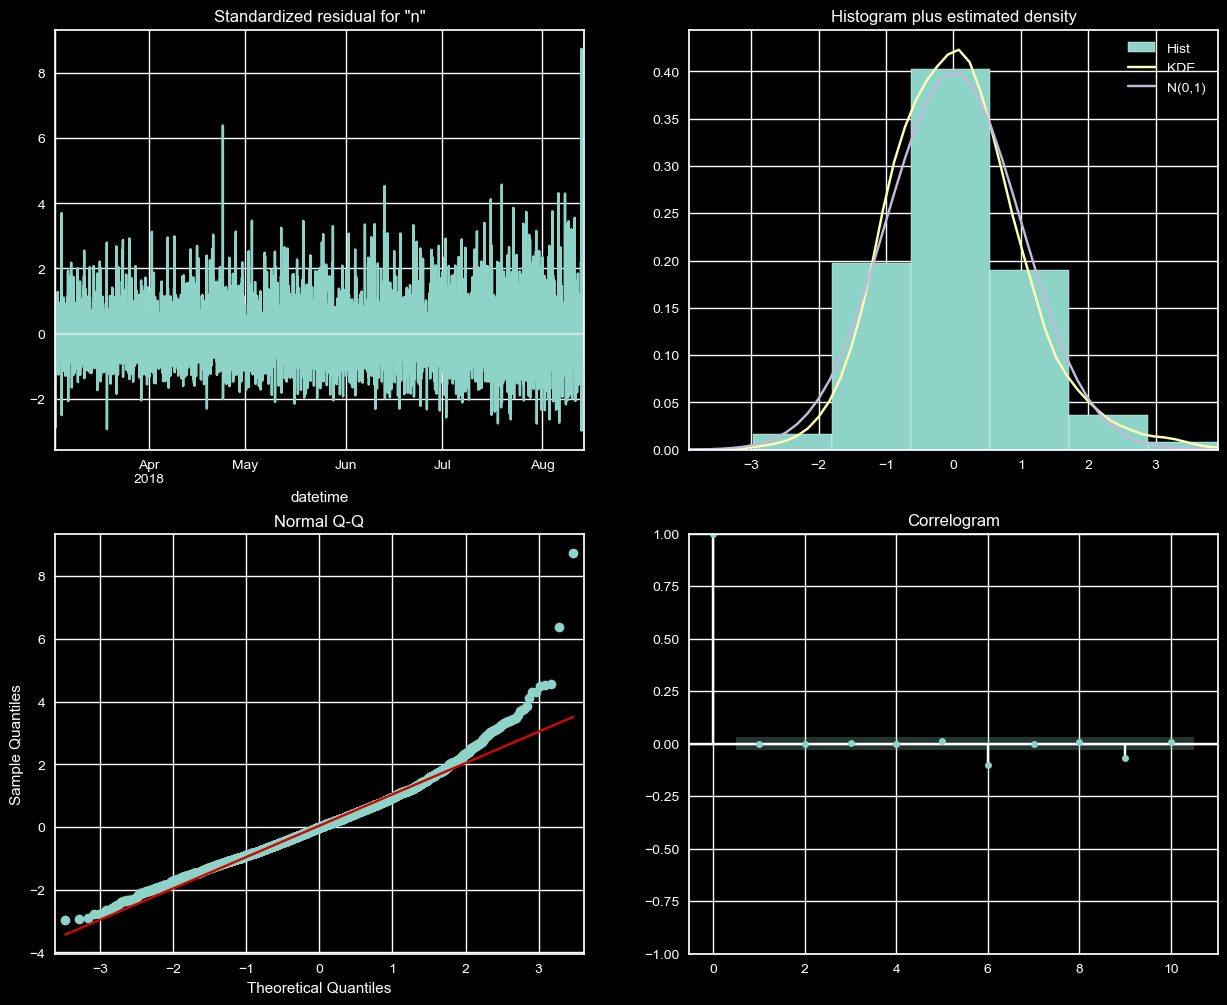

In [42]:
arima_results.plot_diagnostics(figsize=(15, 12))
plt.show()

Присутствует наличие выбросов, которые могут оказывать влияние на точность предсказаний модели. Однако, распределение ошибок имеет вид распределения Гауса - близкую к идеальной. Наибольшее отклонение ошибки получаем на минимальных и максимальных значениях выборки.

In [43]:
# получим rmse для обучающей выборки:
train_predict = arima_results.get_prediction()
print(train_predict.predicted_mean[:10])
arima_train_rmse = np.sqrt(
    mean_squared_error(features_train.iloc[:, 0],
                       train_predict.predicted_mean))
print(features_train.iloc[:10, 0])
print(arima_train_rmse)

datetime
2018-03-03 00:00:00     0.000
2018-03-03 01:00:00   162.933
2018-03-03 02:00:00   125.085
2018-03-03 03:00:00    60.549
2018-03-03 04:00:00    71.878
2018-03-03 05:00:00    70.875
2018-03-03 06:00:00    55.457
2018-03-03 07:00:00    45.350
2018-03-03 08:00:00    41.567
2018-03-03 09:00:00    57.702
Freq: H, Name: predicted_mean, dtype: float64
datetime
2018-03-03 00:00:00   62.750
2018-03-03 01:00:00   65.792
2018-03-03 02:00:00   65.292
2018-03-03 03:00:00   63.208
2018-03-03 04:00:00   63.208
2018-03-03 05:00:00   64.208
2018-03-03 06:00:00   64.375
2018-03-03 07:00:00   64.292
2018-03-03 08:00:00   64.708
2018-03-03 09:00:00   65.125
Freq: H, Name: rolling_mean, dtype: float64
17.688660495815856


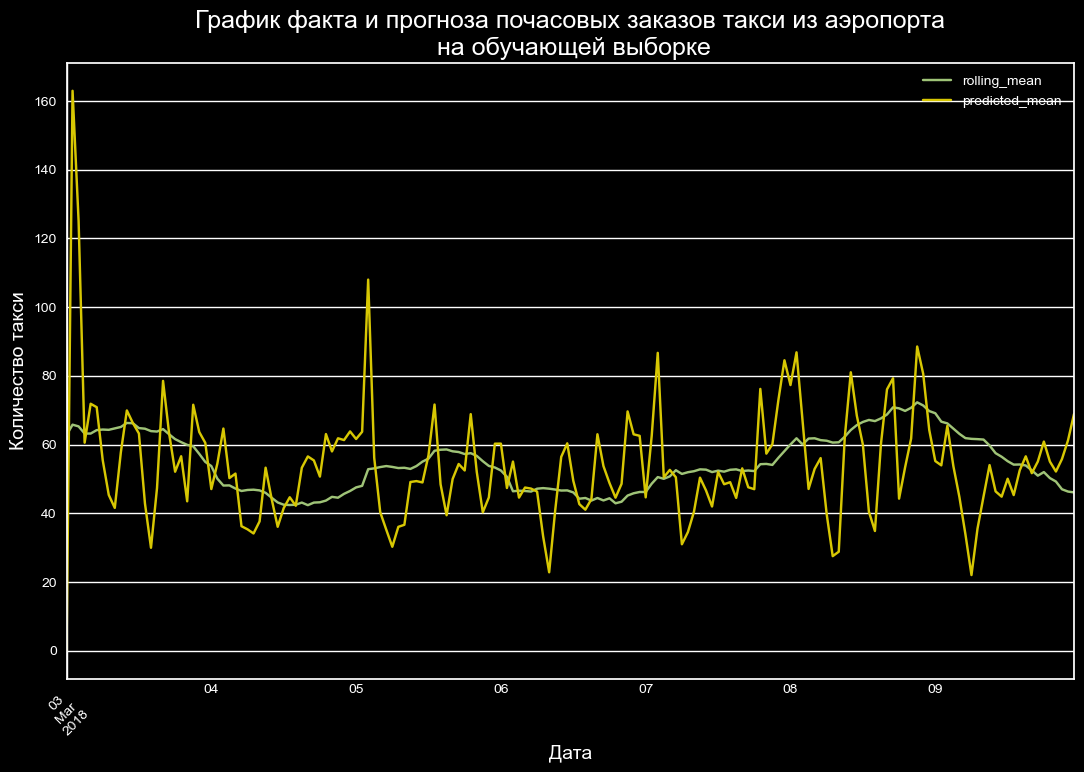

In [44]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.title(' График факта и прогноза почасовых заказов такси из аэропорта \n на обучающей выборке',
          fontsize=18)

features_train.iloc[0:168, 0].plot(color='g')
train_predict.predicted_mean[0:168].plot(color='y')
plt.xlabel('Дата', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Количество такси', fontsize=14)
plt.legend()
plt.show()

### Итоги обучения 
Нами были обучены следующие модели:
- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- CatBoostRegressor
- SARIMA

Худшее значение RMSE было получено на тренировочных данных при обучении модели LinearRegression - 32.790.
Лучшее значение RMSE было получено на тренировочных данных при обучении модели SARIMA - 17.690.

Далее будет проверена на тестовой выборке модель с лучшим результатом.

## Анализ моделей

Проверим на тестовой выборке результат работы модели SARIMA.

In [45]:
# получим rmse для тестовой выборки:
test_predict = arima_results.get_prediction(start=pd.to_datetime('2018-08-13 19:00:00'),
                                            end=pd.to_datetime('2018-08-31 23:00:00'),dynamic=True, full_results=True)
print(test_predict.predicted_mean[:32])

2018-08-13 19:00:00   115.917
2018-08-13 20:00:00   113.690
2018-08-13 21:00:00   117.753
2018-08-13 22:00:00   112.767
2018-08-13 23:00:00   114.523
2018-08-14 00:00:00   113.503
2018-08-14 01:00:00   114.205
2018-08-14 02:00:00   115.016
2018-08-14 03:00:00   112.946
2018-08-14 04:00:00   116.221
2018-08-14 05:00:00   112.527
2018-08-14 06:00:00   114.498
2018-08-14 07:00:00   112.191
2018-08-14 08:00:00   114.821
2018-08-14 09:00:00   114.419
2018-08-14 10:00:00   116.025
2018-08-14 11:00:00   116.149
2018-08-14 12:00:00   116.089
2018-08-14 13:00:00   114.876
2018-08-14 14:00:00   114.795
2018-08-14 15:00:00   115.209
2018-08-14 16:00:00   115.857
2018-08-14 17:00:00   116.005
2018-08-14 18:00:00   115.226
2018-08-14 19:00:00   115.053
2018-08-14 20:00:00   115.014
2018-08-14 21:00:00   115.624
2018-08-14 22:00:00   115.691
2018-08-14 23:00:00   115.573
2018-08-15 00:00:00   115.107
2018-08-15 01:00:00   114.967
2018-08-15 02:00:00   115.121
Freq: H, Name: predicted_mean, dtype: fl

In [46]:
arima_test_rmse = np.sqrt(mean_squared_error(features_test.iloc[:, 0], test_predict.predicted_mean[0:]))
print(features_test.iloc[:32, 0])
print(arima_test_rmse)

datetime
2018-08-13 19:00:00   141.792
2018-08-13 20:00:00   142.167
2018-08-13 21:00:00   141.500
2018-08-13 22:00:00   142.542
2018-08-13 23:00:00   141.958
2018-08-14 00:00:00   139.833
2018-08-14 01:00:00   138.958
2018-08-14 02:00:00   137.208
2018-08-14 03:00:00   123.500
2018-08-14 04:00:00   124.417
2018-08-14 05:00:00   124.250
2018-08-14 06:00:00   122.750
2018-08-14 07:00:00   121.875
2018-08-14 08:00:00   122.500
2018-08-14 09:00:00   122.500
2018-08-14 10:00:00   122.417
2018-08-14 11:00:00   122.375
2018-08-14 12:00:00   123.125
2018-08-14 13:00:00   124.042
2018-08-14 14:00:00   121.750
2018-08-14 15:00:00   122.167
2018-08-14 16:00:00   119.708
2018-08-14 17:00:00   118.333
2018-08-14 18:00:00   118.333
2018-08-14 19:00:00   118.083
2018-08-14 20:00:00   118.833
2018-08-14 21:00:00   118.917
2018-08-14 22:00:00   117.208
2018-08-14 23:00:00   116.250
2018-08-15 00:00:00   119.500
2018-08-15 01:00:00   122.500
2018-08-15 02:00:00   116.958
Freq: H, Name: rolling_mean, dt

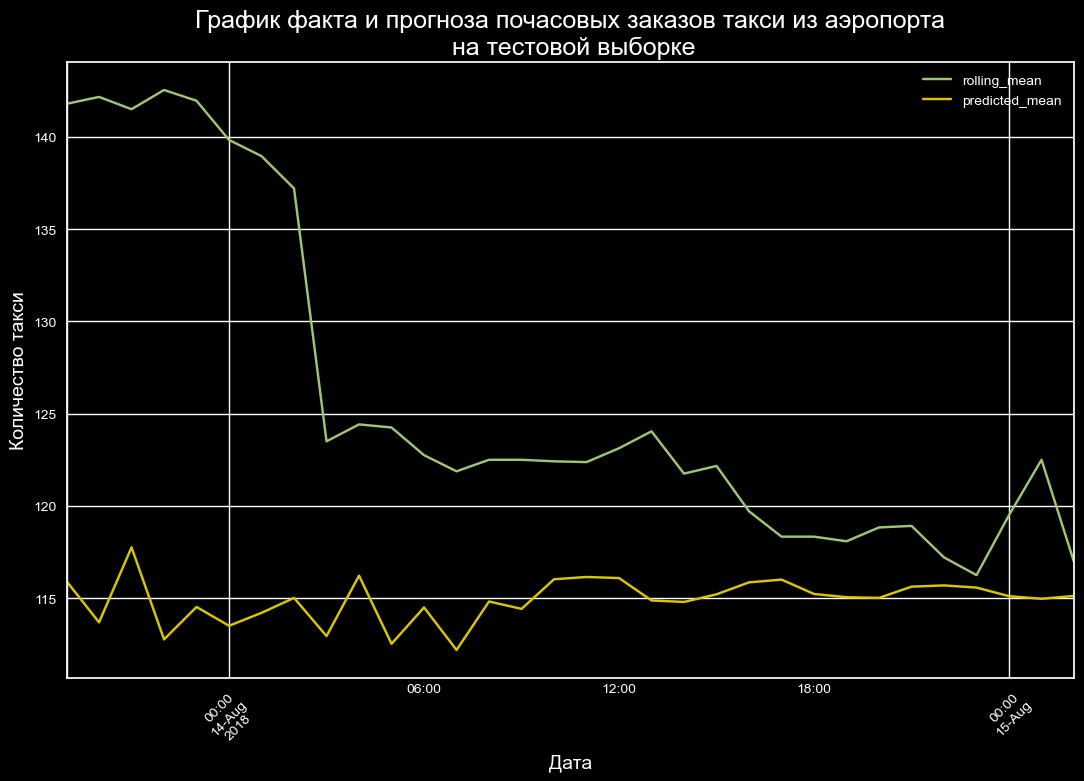

In [47]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.title(' График факта и прогноза почасовых заказов такси из аэропорта \n на тестовой выборке',
          fontsize=18)

features_test.iloc[:32, 0].plot(color='g')
test_predict.predicted_mean[:32].plot(color='y')
plt.xlabel('Дата', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Количество такси', fontsize=14)
plt.legend()
plt.show()

In [48]:
sarima_results = {
        'Model':  'SARIMA',
        'Train RMSE': round(arima_train_rmse, 2),
        'Test RMSE': round(arima_test_rmse, 2),
    }

In [49]:
rating = {
    'LinearRegression':lr_results,
    'DecisionTreeRegressor':dt_results, 
    'RandomForestRegressor': rf_results, 
    'CatBoostRegressor':cbr_results, 
    'SARIMA model': sarima_results,
    
}

In [50]:
analysis = pd.DataFrame(rating).T

In [51]:
analysis

,Model,Train RMSE,Test RMSE
LinearRegression,LinearRegression(),32.790,-
DecisionTreeRegressor,"DecisionTreeRegressor(criterion='mse', max_dep...",32.420,-
RandomForestRegressor,"(DecisionTreeRegressor(max_depth=10, max_featu...",27.990,-
CatBoostRegressor,<catboost.core.CatBoostRegressor object at 0x7...,29.430,-
SARIMA model,SARIMA,17.690,28.460


### Итоги анализа моделей
На тестовых данных RMSE было получено при обучении модели SARIMA - 28.460. Данный результат удовлетворяет условию: значение метрики RMSE на тестовой выборке должно быть не больше 48.
Модель SARIMA может быть использована для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.


## Общий вывод

Мы анализировали данные о заказах такси в аэропортах , которые содержат 26496 наблюдения за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 включительно.

Со временем наблюдается тенденция к большему заказу такси из аэропортов.

Тенденция означает, что набор данных почти наверняка является нестационарным(по наличию или отсутствию тенденций и сезонных эффектов), и очевидное изменение флуктуации также может внести свой вклад.

В результате анализа данных было установлено, что набор данных является нестационарным так как:
- наблюдвется тренд - тенденция к увеличению числа заказов
- наблюдаются сезонные эффекты: ближе к середине и концу месяца вызывают такси чаще одинаковы

Нами были обучены следующие модели:
- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- CatBoostRegressor
- SARIMA

Худшее значение RMSE было получено на тренировочных данных при обучении модели LinearRegression - 32.790	.

Лучшее значение RMSE было получено на тренировочных данных при обучении модели SARIMA - 17.690.

На тестовых данных RMSE было получено при обучении модели SARIMA - 28.460. Данный результат удовлетворяет условию: значение метрики RMSE на тестовой выборке должно быть не больше 48.   

In [52]:
analysis

,Model,Train RMSE,Test RMSE
LinearRegression,LinearRegression(),32.790,-
DecisionTreeRegressor,"DecisionTreeRegressor(criterion='mse', max_dep...",32.420,-
RandomForestRegressor,"(DecisionTreeRegressor(max_depth=10, max_featu...",27.990,-
CatBoostRegressor,<catboost.core.CatBoostRegressor object at 0x7...,29.430,-
SARIMA model,SARIMA,17.690,28.460


Модель SARIMA может быть использована для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.